# Introduction
Train a model to predict the current market value of a player
• Compare at least two different models
• Identify what are the most informative features
• Does the team the player is actually enrolled on influences his market value?

# Step 0
Reading data and checking initial feature

In [1]:
#some useful library and necessary things
import pandas as pd
import numpy as np 


from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display



In [2]:
#Read data from .csv file

f_players = pd.read_csv("train.csv")
"""
Firstly I read data sets and clarify which one is not necessary for our problem..

display(f_players.head())
print(f"Total number of rows: {f_players.shape[0]}\nTotal number of columns: {f_players.shape[1]}")

#These are unnecessary for us. ID,Name,Photo,Flag,Club logo,Real Face,Jersey Number,Joined, Realese Clause and Loaned from

"""
# fp is our new data set. 
drop_columns = [ 'Unnamed: 0', 'ID','Nationality','Name', 'Photo','Preferred Foot', 'Flag','Club Logo', 'Body Type', 'Real Face', 'Jersey Number','Joined', 'Loaned From','Release Clause','Contract Valid Until']
fp = f_players.copy()
fp.drop(drop_columns, axis =1 , inplace = True)
#fp.drop(['Unnamed: 0,'ID', 'Name', 'Photo','Flag','Club Logo','Body Type', 'Real Face','Jersey Number','Joined', 'Loaned From','Release Clause','Contract Valid Until'], axis=1, inplace=True)
#fp.drop(fp.columns[[0]], axis=1,inplace = True)

In [3]:
display(fp.head())
print(f"Total number of rows: {fp.shape[0]}\nTotal number of columns: {fp.shape[1]}")


,Age,Overall,Potential,Club,Value,Wage,Special,International Reputation,Weak Foot,Skill Moves,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,FC Barcelona,€110.5M,€565K,2202,5.0,4.0,4.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,Juventus,€77M,€405K,2228,5.0,4.0,5.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,Paris Saint-Germain,€118.5M,€290K,2143,5.0,5.0,5.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,Manchester United,€72M,€260K,1471,4.0,3.0,1.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,Manchester City,€102M,€355K,2281,4.0,5.0,4.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


Total number of rows: 18207
Total number of columns: 74


In [4]:
" Before the analysis value we need to change type of Value to float."
" Example: Kevin de Bruyne Value = €102M	 €102*1000000 and wage= €355K	 €355000"

def str2float(amount):
    """
    This function help to us for convert string to float.
       
    """
   
    if amount[-1] == 'M':
        return float (amount[1:-1])*1000000
    elif amount[-1] == 'K':
        return float (amount[1:-1])*1000
    else:
        return float(amount[1:])
    
fp['Value_Float'] = fp['Value'].apply(lambda x: str2float(x))
fp['Wage_Float'] = fp ['Wage'].apply(lambda x: str2float(x))

#Now we do not need string value and wage. We can drop them

fp.drop(['Value','Wage'] ,axis =1 , inplace = True)

In [5]:
display(fp.head())
print(f"Total number of rows: {fp.shape[0]}\nTotal number of columns: {fp.shape[1]}")

,Age,Overall,Potential,Club,Special,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value_Float,Wage_Float
0,31,94,94,FC Barcelona,2202,5.0,4.0,4.0,Medium/ Medium,RF,...,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500000.0,565000.0
1,33,94,94,Juventus,2228,5.0,4.0,5.0,High/ Low,ST,...,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000000.0,405000.0
2,26,92,93,Paris Saint-Germain,2143,5.0,5.0,5.0,High/ Medium,LW,...,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500000.0,290000.0
3,27,91,93,Manchester United,1471,4.0,3.0,1.0,Medium/ Medium,GK,...,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000000.0,260000.0
4,27,91,92,Manchester City,2281,4.0,5.0,4.0,High/ High,RCM,...,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,102000000.0,355000.0


Total number of rows: 18207
Total number of columns: 74


In [6]:
display(fp.isnull().sum())

plt.show()

Age                0
Overall            0
Potential          0
Club             241
Special            0
                ... 
GKKicking         48
GKPositioning     48
GKReflexes        48
Value_Float        0
Wage_Float         0
Length: 74, dtype: int64

In [7]:
## Club has a 241 missing and GKKicking 48, and we are dropping these missing datapoints

fp = fp.loc[fp['Club'].notnull()].copy()
fp = fp.loc[fp['GKKicking'].notnull()].copy()


In [8]:
display(fp.isnull().sum())

Age              0
Overall          0
Potential        0
Club             0
Special          0
                ..
GKKicking        0
GKPositioning    0
GKReflexes       0
Value_Float      0
Wage_Float       0
Length: 74, dtype: int64

# Step 1
Value (Target Datapoints).

Mainly we are focusing on players market values. On this part, we will looking this area.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


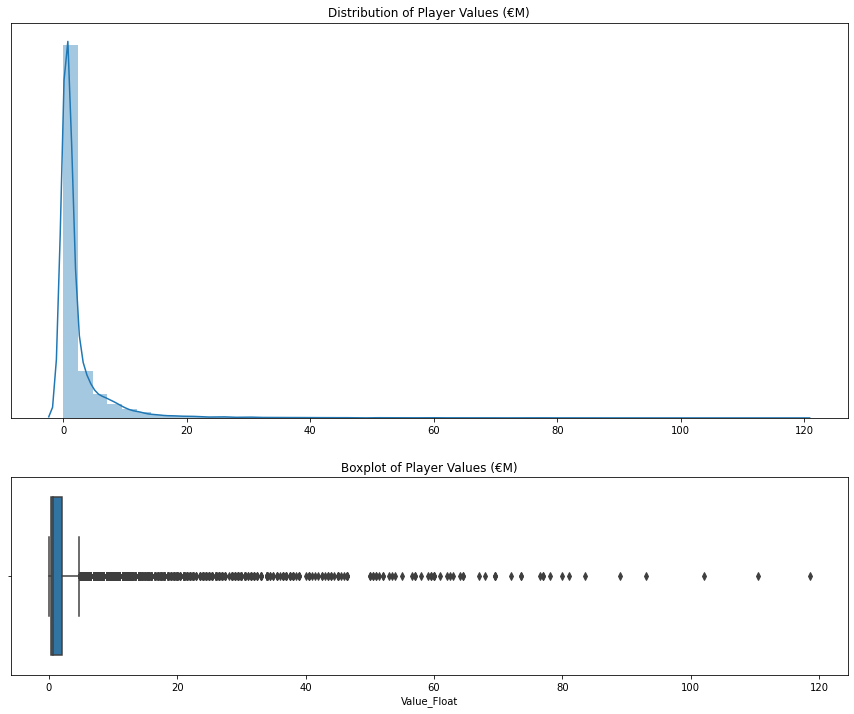

,Value_Float
count,17918.000000
mean,2.448629
std,5.631804
min,0.000000
25%,0.325000
50%,0.700000
75%,2.100000
max,118.500000


In [9]:
def distribution_and_stats_plot(variable,Name):
    """For better understanding for players value distribution.I will draw a plot charts"""
    
    fig, ax = plt.subplots(nrows=2,figsize =(15,12),gridspec_kw={'height_ratios': [2,1]})
    sns.distplot(variable, ax = ax[0])
    ax[0].set(title = f"Distribution of {Name}",xlabel='',ylabel='')
    ax[0].set_yticks([])
    
    ax[1]=sns.boxplot(x=variable.columns[0],y=None,data=variable)
    ax[1].set_title(f"Boxplot of {Name}")
    plt.show()
    #sns.boxplot(x="distance", y="method", data=planets,  whis=[0, 100], width=.6, palette="vlag")
   


    
    display(variable.describe())
    
distribution_and_stats_plot(fp[["Value_Float"]]/1000000,'Player Values (\N{euro sign}M)')



### Step 1.1

#### Player  Value
As you can see the above, our players generally have low market value and for this reason, we can not see general 
the distribution of that. High prices players are almost not seeing on the chart. For that, we can use a logarithmic distribution chart, it shows us more clearly.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


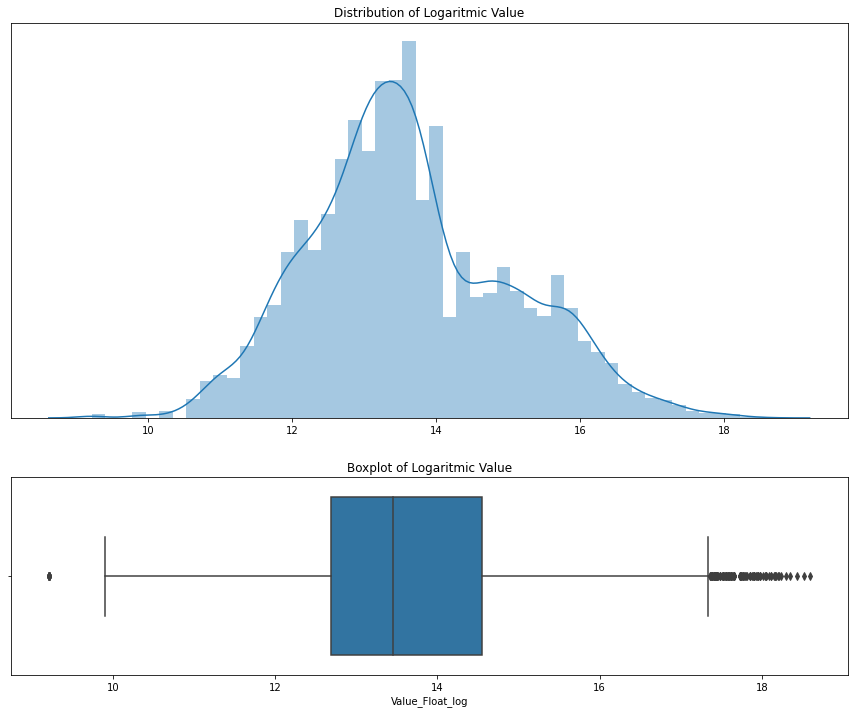

,Value_Float_log
count,17907.000000
mean,13.622829
std,1.407122
min,9.210440
25%,12.691584
50%,13.458837
75%,14.557448
max,18.590424


In [10]:
# In my data set there are 11 values equal 0 that is why, I added plus 1 for every values for converting log 
# After that I reaileze that 11 players old person and low overall rating. They do not any good affect on model.
# For this reason I deleted them and now my graphs is better than befor more clear and understandable.
#
#Convert to log

fp["Value_Float_log"] = np.log(fp["Value_Float"]+1)

#delete value_log=0 
fp =fp[fp["Value_Float_log"] !=0]

distribution_and_stats_plot(fp[["Value_Float_log"]],'Logaritmic Value')


### Step 1.2
#### Age
The step where the players are shown to the age distribution!!

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


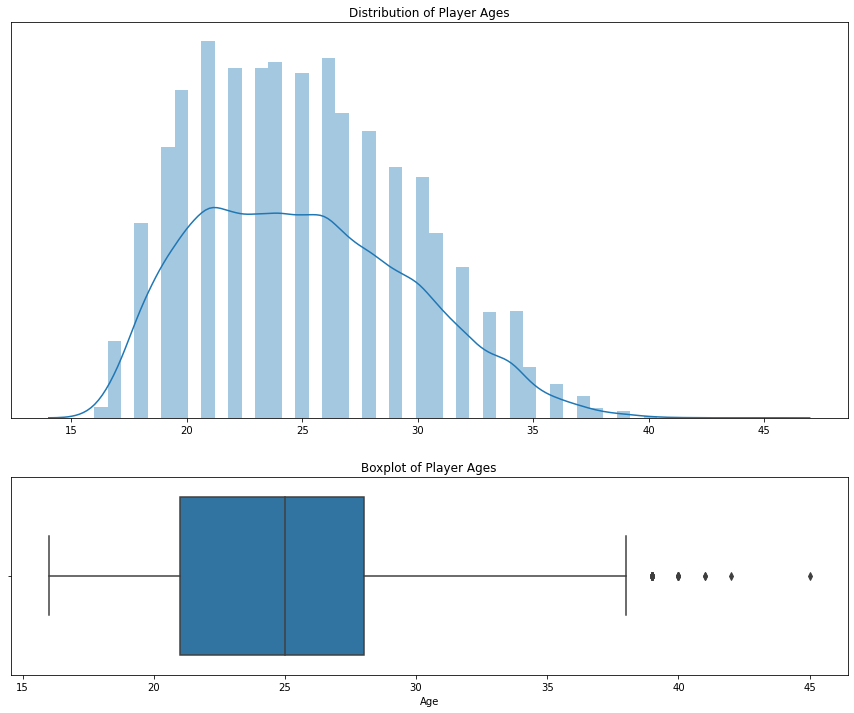

,Age
count,17907.000000
mean,25.095605
std,4.660388
min,16.000000
25%,21.000000
50%,25.000000
75%,28.000000
max,45.000000


In [11]:
distribution_and_stats_plot(fp[["Age"]],'Player Ages')

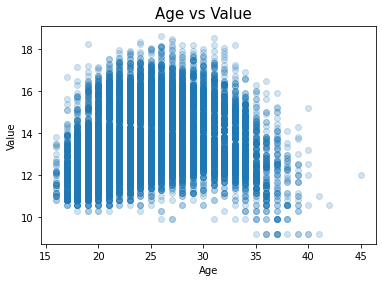

Pearson correlation = 0.07845203553213996


In [12]:
from scipy.stats import pearsonr

plt.scatter(x=fp["Age"],y=fp["Value_Float_log"],alpha=0.2)
plt.suptitle("Age vs Value",fontsize=15,y=0.95)
plt.xlabel("Age")
plt.ylabel("Value")
plt.show()

print(f"Pearson correlation = {pearsonr(fp['Value_Float'],fp['Age'])[0]}")

### Step 1.3

#### Player Position


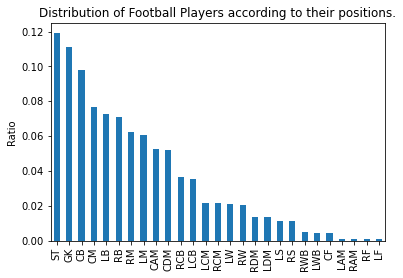

Number of positions= 27


In [13]:
fp['Position'].value_counts(normalize= True).plot(kind='bar')
plt.title("Distribution of Football Players according to their positions.")
plt.ylabel("Ratio")
plt.show()

print(f"Number of positions= {len(fp['Position'].unique())}")

As you can see the above graphic, the most common positions are ST and GK. 

We have 27 unique positions. It's too much for analysis that's why we can classify these as, Attacker, midfielder, defender and goalkeeper. For that I will create new function.

In [14]:
def classify_position(position):
    
    Position_dict= { 'Attack' : ['ST','LS','RS','CF','RF','LF'],
                    'Midfield': ['CM','RM','LM','CAM','CDM','LCM','RCM','LW','RW','RDM','LDM','LAM','RAM'],
                     'Defence': ['CB','LB','RB','RCB','LCB','RWB','LWB'],
                   'GoalKeeper':['GK']}
    
    for group , position_list in Position_dict.items():
        
        if position in position_list:
            return group
    
    return np.nan

In [15]:
fp['Position_classify'] = fp['Position'].apply(classify_position)

## We classify our dataset, and we do not need fp['Position']
fp.drop(['Position'] ,axis =1 , inplace = True)

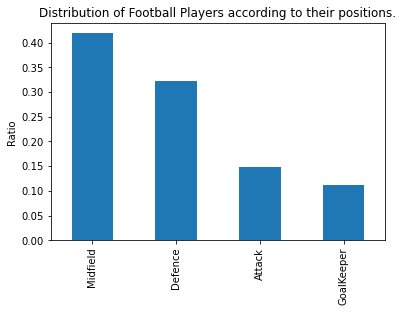

In [16]:
fp['Position_classify'].value_counts(normalize= True).plot(kind='bar')
plt.title("Distribution of Football Players according to their positions.")
plt.ylabel("Ratio")
plt.show()

##This chart shows a clearer distribution of players' positions.

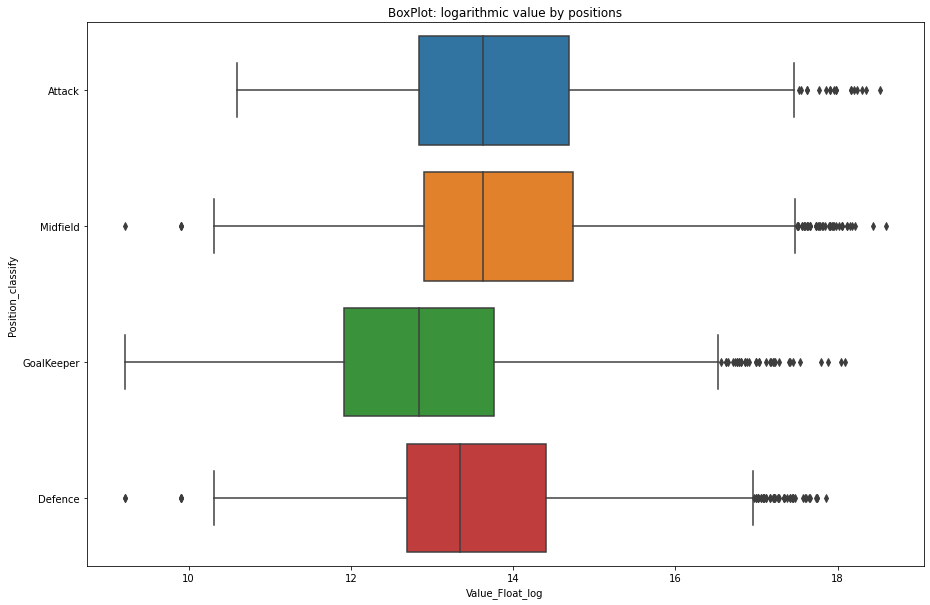

In [17]:
plt.figure(figsize=(15,10))
sns.boxplot(x="Value_Float_log",y="Position_classify",data=fp)
plt.title("BoxPlot: logarithmic value by positions")
plt.show()

As you can see above, the distribution's Daily Market Value is very close to each. Attacker and Midfield players have average highs value and the goalkeeper average low, which is expected.

### Step 1.4

#### Player Potential

In this section, we will examine the distribution of the predicted potential of football players.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


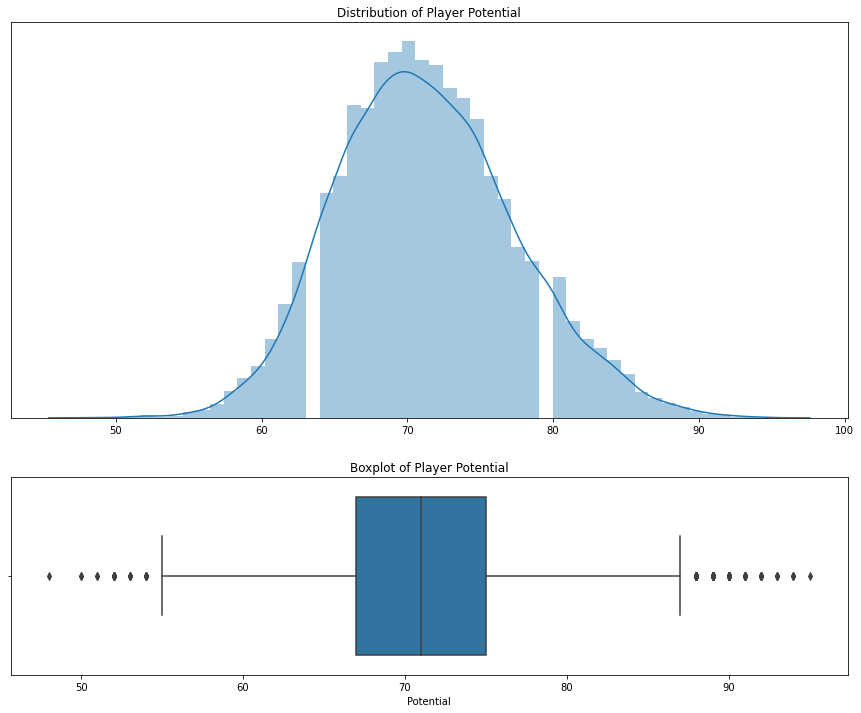

,Potential
count,17907.000000
mean,71.335232
std,6.137251
min,48.000000
25%,67.000000
50%,71.000000
75%,75.000000
max,95.000000


In [18]:
distribution_and_stats_plot(fp[["Potential"]],'Player Potential')

The chart is more or less normally distributed and with a mean 71.32.

Also, we can examine in detail the player potential according to their positions.

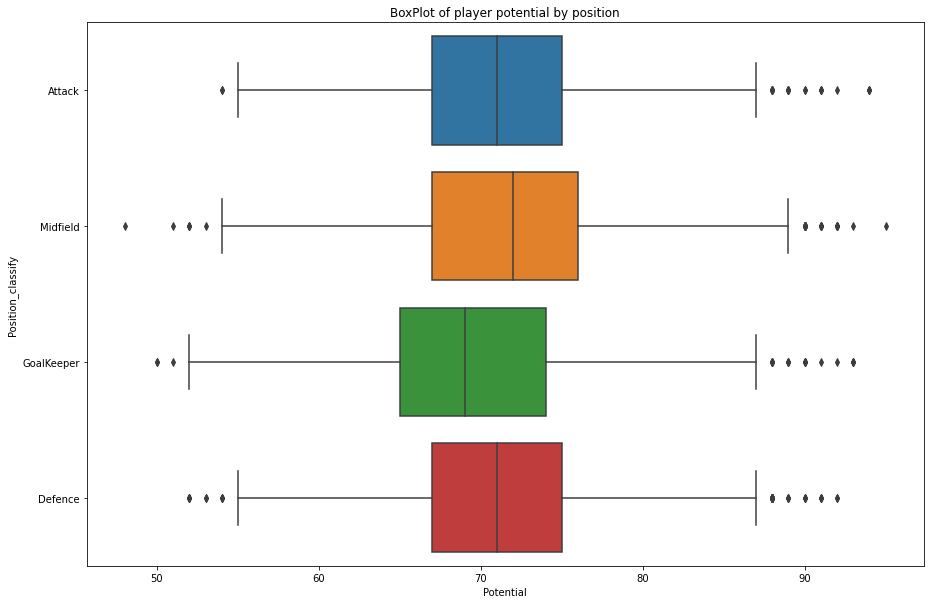

In [19]:
plt.figure(figsize=(15,10))
sns.boxplot(x="Potential",y="Position_classify",data=fp)
plt.title("BoxPlot of player potential by position")
plt.show()

The potential of player does not seem much different for each position. Next step, we will look relationship between player potential and player values. 

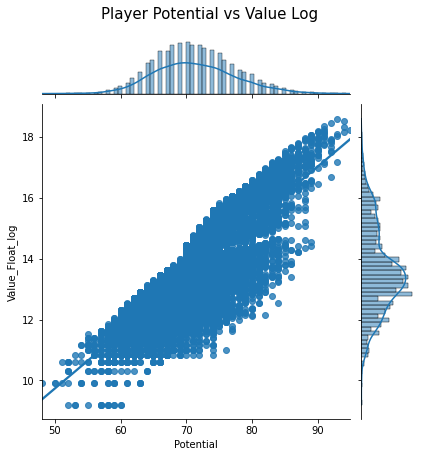

In [20]:
sns.jointplot(x='Potential',y="Value_Float_log",data=fp,kind='reg')
plt.suptitle("Player Potential vs Value Log", fontsize=15,y=1.05)
plt.show()

The graphic turned out as expected. As you can see above, if a player has high potential it also has high market values. They are correlated.

This situation also expected between overall rating and potential. These are correlated. I wiil show them on next step.

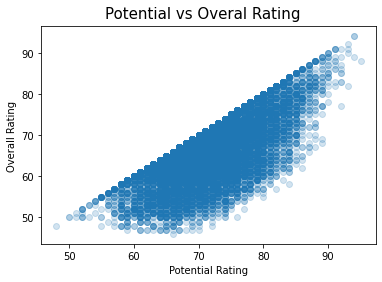

Pearson correlation = 0.6604089398648244


In [21]:
plt.scatter(x=fp["Potential"],y=fp["Overall"],alpha=0.2)
plt.suptitle("Potential vs Overal Rating",fontsize=15,y=0.95)
plt.xlabel("Potential Rating")
plt.ylabel("Overall Rating")
plt.show()

print(f"Pearson correlation = {pearsonr(fp['Potential'],fp['Overall'])[0]}")

You can see the above graphs, potential rating is higher than overall rating, that makes sense. But correlation is not enough for the eliminate one feature, for this reason I will keep both of them.

Next step, I will look difference between potential and overall rating. It can be a nice feature to show the effect of 
potential rating increase on market value.


# BUNU BELKİ SİLEBİLİRSİN SADECE YORUM YAPMAK İÇİN KULLANILIYOR 

In [22]:
# Potential Growth
fp['PotentialGrowth'] = fp['Potential']-fp['Overall']

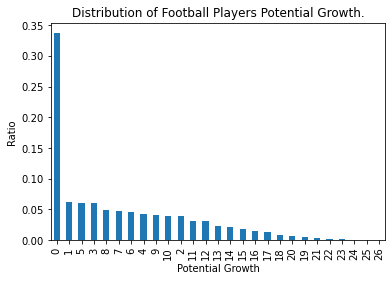

In [23]:
fp['PotentialGrowth'].value_counts(normalize= True).plot(kind='bar')
plt.title("Distribution of Football Players Potential Growth.")
plt.xlabel("Potential Growth")
plt.ylabel("Ratio")
plt.show()

yorum yaz blalallalalalalallala




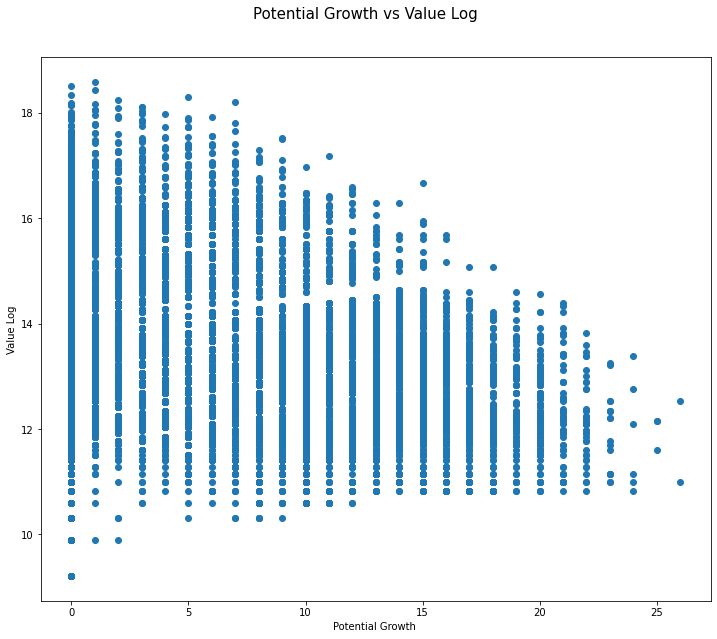

Pearson correlation = -0.1503113006956136


In [24]:
plt.figure(figsize=(12,10))
plt.scatter(x="PotentialGrowth",y="Value_Float_log",data=fp)
plt.suptitle("Potential Growth vs Value Log",fontsize=15,y=0.95)
plt.xlabel("Potential Growth ")
plt.ylabel("Value Log")
plt.show()

print(f"Pearson correlation = {pearsonr(fp['Value_Float'],fp['PotentialGrowth'])[0]}")

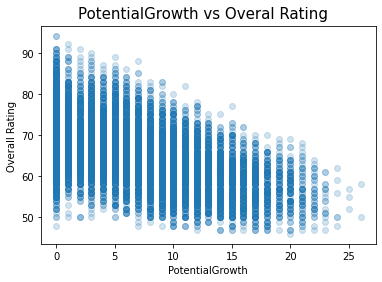

Pearson correlation = -0.5291261822409619


In [25]:
plt.scatter(x=fp["PotentialGrowth"],y=fp["Overall"],alpha=0.2)
plt.suptitle("PotentialGrowth vs Overal Rating",fontsize=15,y=0.95)
plt.xlabel("PotentialGrowth")
plt.ylabel("Overall Rating")
plt.show()

print(f"Pearson correlation = {pearsonr(fp['PotentialGrowth'],fp['Overall'])[0]}")

In [26]:
#### yorumm 

In [27]:
#del fp['PotentialGrowth']

### Step 1.5

#### Player Overall Rating

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


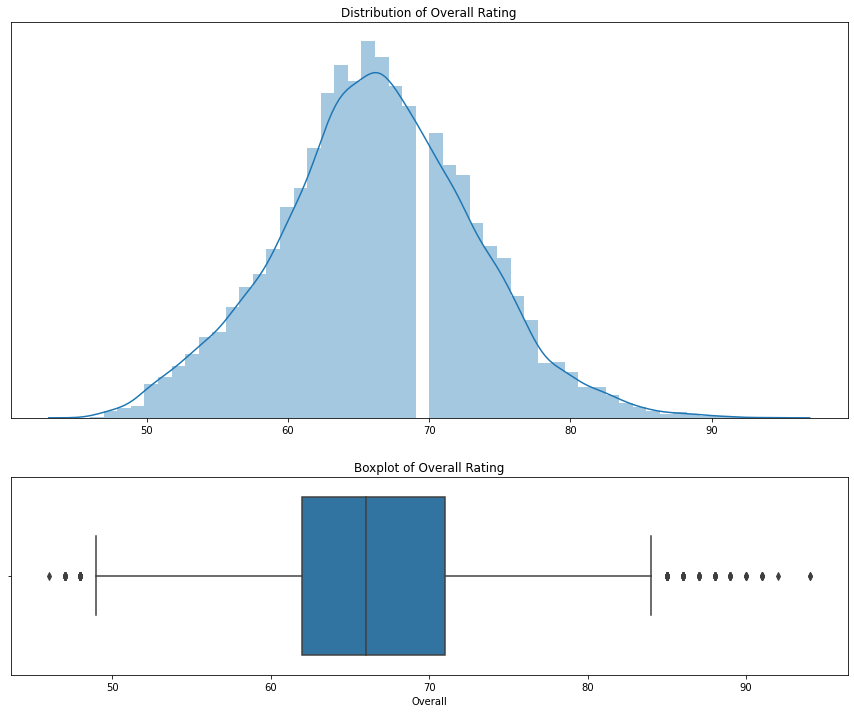

,Overall
count,17907.000000
mean,66.239571
std,6.926818
min,46.000000
25%,62.000000
50%,66.000000
75%,71.000000
max,94.000000


In [28]:
distribution_and_stats_plot(fp[["Overall"]],'Overall Rating')

Overal rating is normally distributed with a average of 66, minimum 46 and maximum 94.

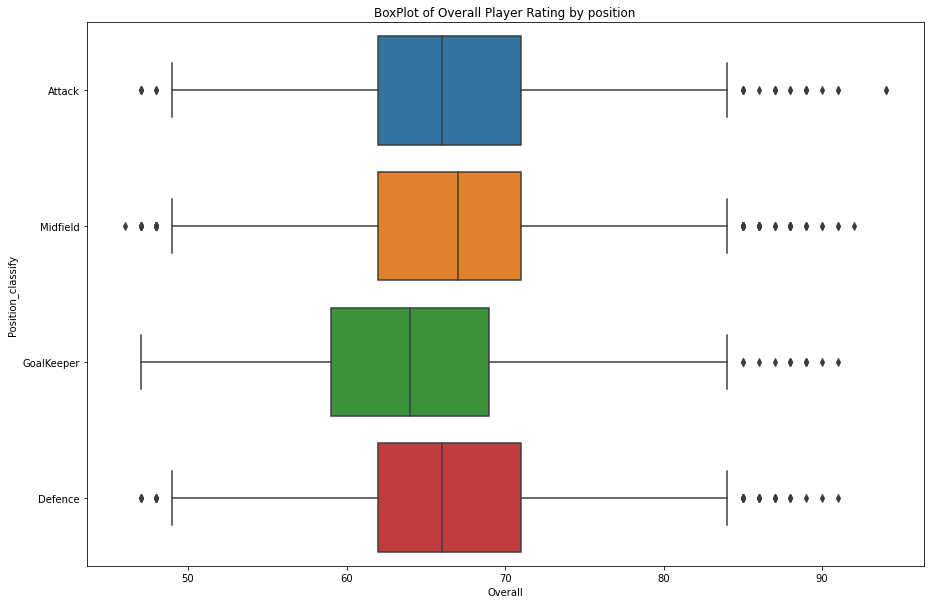

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(x="Overall",y="Position_classify",data=fp)
plt.title("BoxPlot of Overall Player Rating by position")
plt.show()

Except for Goalkeepers, other position more or less has the same overall rating. This interesting because as we see before on the logarithmic value by positions chart attackers and midfields market value higher than the others. 

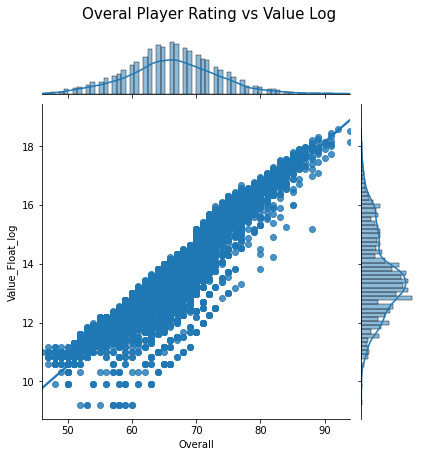

Pearson correlation = 0.9384379114329584
R2= 0.8806657136146531


In [30]:
sns.jointplot(x='Overall',y="Value_Float_log",data=fp,kind='reg')
plt.suptitle("Overal Player Rating vs Value Log", fontsize=15,y=1.05)
plt.show()

print(f"Pearson correlation = {pearsonr(fp['Value_Float_log'],fp['Overall'])[0]}")
print(f"R2= {pearsonr(fp['Value_Float_log'],fp['Overall'])[0]**2}")

In [31]:
### Yorummmm yapılabilir.

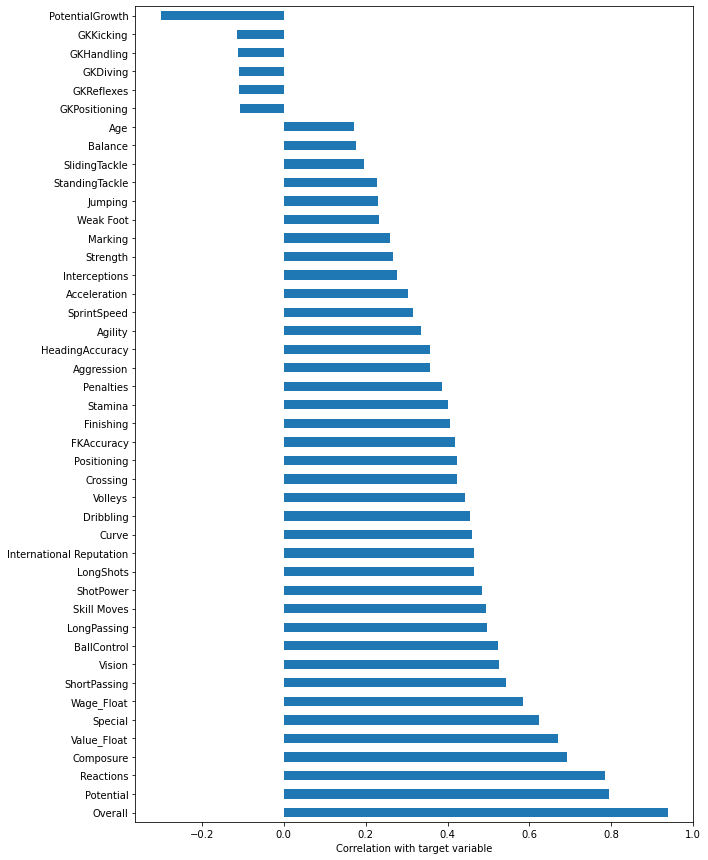

In [32]:
from IPython.core.display import display, HTML
display(HTML("<b>Feature Correlations to the target variable, log(Value_Float)<b>"))
fp.corr()["Value_Float_log"].sort_values(ascending=False).iloc[1:].plot(kind='barh',figsize=(10,15))
plt.xlabel("Correlation with target variable")
plt.show()

# Step 2 
 
## Modeling 


#### 2.1 Data Pre.


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def loaddataset():
    """Datayı yükleeee"""
    
    #read and load initial data 
    f_players = pd.read_csv("train.csv")
    
    # fp is our new data set. 
    drop_columns = [ 'Unnamed: 0', 'ID','Name', 'Photo', 'Flag','Club Logo', 'Body Type', 'Real Face', 'Jersey Number','Joined', 'Loaned From','Release Clause','Contract Valid Until']
    fp = f_players.copy()
    fp.drop(drop_columns, axis =1 , inplace = True)
    
    #Change the type of wage and value
    fp['Value_Float'] = fp['Value'].apply(lambda x: str2float(x))
    fp['Wage_Float'] = fp ['Wage'].apply(lambda x: str2float(x))
    
    #Delete the prev value and wage
    fp.drop(['Value','Wage'] ,axis =1 , inplace = True)
    
    ## Dropping these missing datapoints
    fp = fp.loc[fp['Club'].notnull()].copy()
    fp = fp.loc[fp['GKKicking'].notnull()].copy()
    
    #Convert to log
    fp["Value_Float_log"] = np.log(fp["Value_Float"]+1)
    fp =fp[fp["Value_Float_log"] !=0]
    fp.drop(["Value_Float"] ,axis =1 , inplace = True)
    
    # Potential Growth
    fp['PotentialGrowth'] = fp['Potential']-fp['Overall']
    
    
    
    # Shuffled the dataframe list
    fp_sh = shuffle(fp, random_state = 0)
    
    #train and test data seperated
    return train_test_split( fp_sh.iloc[:,:-1],
                             fp_sh.iloc[:,-1],
                             test_size=0.33,
                             random_state=0)

In [34]:
##training and final test sets
X_train, X_test, y_train, y_test = loaddataset()

In [35]:
X_test

,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Wage_Float,Value_Float_log
9914,24,Austria,66,69,SCR Altach,1649,Right,1.0,3.0,3.0,...,52.0,49.0,39.0,14.0,12.0,6.0,8.0,14.0,4000.0,13.623140
15351,27,Republic of Ireland,59,59,Bohemian FC,1503,Right,1.0,4.0,3.0,...,29.0,38.0,37.0,6.0,12.0,13.0,12.0,10.0,1000.0,11.982935
15165,19,Netherlands,60,71,Heracles Almelo,1278,Right,1.0,2.0,2.0,...,56.0,67.0,63.0,6.0,13.0,9.0,6.0,8.0,1000.0,12.611541
7909,31,Argentina,67,67,San Martín de San Juan,1761,Left,1.0,3.0,3.0,...,32.0,31.0,27.0,9.0,6.0,7.0,11.0,16.0,6000.0,13.422469
9069,22,Italy,66,78,Benevento,1059,Right,1.0,1.0,1.0,...,10.0,19.0,11.0,65.0,64.0,60.0,62.0,72.0,1000.0,13.710151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16890,19,Norway,56,67,Ranheim Fotball,1440,Left,1.0,3.0,2.0,...,32.0,32.0,28.0,9.0,12.0,13.0,7.0,11.0,1000.0,11.918397
7485,25,Netherlands,68,71,Heracles Almelo,1814,Left,1.0,3.0,3.0,...,40.0,54.0,51.0,8.0,12.0,15.0,15.0,7.0,4000.0,13.910822
16298,20,Italy,57,72,FC Lugano,1417,Right,1.0,3.0,2.0,...,35.0,18.0,18.0,6.0,12.0,12.0,14.0,15.0,1000.0,12.345839
474,25,Germany,80,81,TSG 1899 Hoffenheim,1988,Left,1.0,2.0,3.0,...,74.0,76.0,77.0,13.0,9.0,15.0,7.0,14.0,37000.0,16.489659


## Step 2.2 Baseline


In [36]:
### yorummmmm

In [37]:
#dictionary for the store results
results = {}

### r-squared

def calculate_r2(trainingdata,r2):
    
    x = len(trainingdata)
    y = len(trainingdata.columns)
    
    return 1-((1-r2)*(x-1)/(x-y-1))

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = X_train ["Potential"].values.reshape(-1,1)
y = y_train.values.reshape(-1,1)

baseline_m = LinearRegression()
baseline_m.fit(x,y)

baseline_p = baseline_m.predict(X_train["Potential"].values.reshape(-1,1))
baseline_rmse = np.sqrt(mean_squared_error(y_train,baseline_p))
baseline_r2 = r2_score(y_train,baseline_p)
baseline_adj_r2 = calculate_r2(X_train[["Potential"]],baseline_r2)

###
results['Baseline Model- Linear Regression'] = {'RMSE':baseline_rmse, 'ADJ.R2':baseline_r2}

pd.DataFrame.from_dict(results,orient= 'index')

,RMSE,ADJ.R2
Baseline Model- Linear Regression,5.161947,0.085065


##### 222

## Step 2.3 Multiple

In [ ]:
## 
X_train_mult = pd.get_dummies(X_train,drop_first=True)
X_test_mult = pd.get_dummies(X_test,drop_first=True)

X_train_mult.head()

In [ ]:
import statsmodels.api as sm



In [ ]:
def gradientDescent(X,Y,theta,alpha,n_iteration):
    
    """RADIENTDESCENT Performs gradient descent to learn theta"""
    import numpy as np
    m = len(Y)
    J_hist = np.zeros((n_iteration,1))
    
    for iteration in range(n_iteration):
        h = np.dot(X,theta)
        
        for i in range(X.shape[1]):
            col = X.columns[i]
            theta[i]=theta[i]-alpha/m*sum(np.dot(X[col],(np.subtract(Y,h))))
            
        
        J_hist